## Distance between interpolated images in neural network space

We've created a set of images that interpolate between two base images (e.g. grass, leaves). Those images are made by initializing a noise image and iterating it to match the featural co-occurances to another image - or, in our case, to weighted sums of the featural co-occurances of two different images. We hope/expect that these interpolated images fall along some 1-d axis - the same way that contrast, or orientation does. The goal of this notebook is to test if this is case with our synthesized images. Here, "distance" is implemented in neural network space - the L1 difference between the activations of features in some late pooling layer of vgg19.

### Import and build model

First, measure the activations of vgg19 to the different images. We used vgg19 to synthesize the images by matching the gramians at different layers (the correlation matrix of the feature activations in different pooling layers).

In [1]:
## Import models and other stuff ##
import pdb
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import itertools
import pickle
import warnings
from scipy.optimize import fmin
from scipy.stats import norm
from PIL import Image
import random
warnings.filterwarnings("ignore", message="The default value of `normalized_stress` will change", category=FutureWarning)

# Function to get the model and preprocess_input function
def get_model_and_preprocessing(model_name):
    global conv1, pool1, pool2, pool3, pool4, pool5, end
    input_size = (224, 224, 3)  # Default input size
    if model_name == 'VGG19':
        from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
        base_model = VGG19(include_top=True, input_tensor=Input(shape=input_size))
        conv1 = 1; pool1 = 3; pool2 = 6; pool3 = 11; pool4 = 16; pool5 = 21; end = 25;
    elif model_name == 'ResNet50':
        from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
        base_model = ResNet50(include_top=True, input_tensor=Input(shape=input_size))
        conv1 = 2; pool1 = 6; pool2 = 38; pool3 = 80; pool4 = 142; pool5 = 174; end = 176;
    elif model_name == 'InceptionV3':
        from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
        input_size = (299, 299, 3)  # InceptionV3 uses a larger input size
        base_model = InceptionV3(include_top=True, input_tensor=Input(shape=input_size))
    elif model_name == 'EfficientNetB0':
        from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
        base_model = EfficientNetB0(include_top=True, input_tensor=Input(shape=input_size))
    elif model_name == 'EfficientNetV2B0':
        from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
        base_model = EfficientNetV2B0(include_top=True, input_tensor=Input(shape=input_size))
    else:
        raise ValueError("Model name not recognized. Please choose a valid model name.")
    
    # Build the model with all layers' outputs
    model = Model(inputs=base_model.input, outputs=[base_model.get_layer(layer_name).output for layer_name in [layer.name for layer in base_model.layers]])
    
    return model, preprocess_input, input_size

# Initialize the layers you want to look at. Will get defined when you run the next chunk
global conv1, pool1, pool2, pool3, pool4, pool5, end
conv1, pool1, pool2, pool3, pool4, pool5, end = None, None, None, None, None, None, None


### Get activations to all interpolated images

['grass_leaves', 'lemons_bananas', 'petals_buttercream', 'acorns_redwood']
out/grass_leaves/10x10/grass_0.0_leaves_10x10_pool4_smp1.png
out/grass_leaves/10x10/grass_0.1_leaves_10x10_pool4_smp1.png
out/grass_leaves/10x10/grass_0.2_leaves_10x10_pool4_smp1.png
out/grass_leaves/10x10/grass_0.3_leaves_10x10_pool4_smp1.png
out/grass_leaves/10x10/grass_0.4_leaves_10x10_pool4_smp1.png
out/grass_leaves/10x10/grass_0.5_leaves_10x10_pool4_smp1.png
out/grass_leaves/10x10/grass_0.6_leaves_10x10_pool4_smp1.png
out/grass_leaves/10x10/grass_0.7_leaves_10x10_pool4_smp1.png
out/grass_leaves/10x10/grass_0.8_leaves_10x10_pool4_smp1.png
out/grass_leaves/10x10/grass_0.9_leaves_10x10_pool4_smp1.png
out/grass_leaves/10x10/grass_1.0_leaves_10x10_pool4_smp1.png
out/lemons_bananas/10x10/lemons_0.0_bananas_10x10_pool4_smp1.png
out/lemons_bananas/10x10/lemons_0.1_bananas_10x10_pool4_smp1.png
out/lemons_bananas/10x10/lemons_0.2_bananas_10x10_pool4_smp1.png
out/lemons_bananas/10x10/lemons_0.3_bananas_10x10_pool4_smp

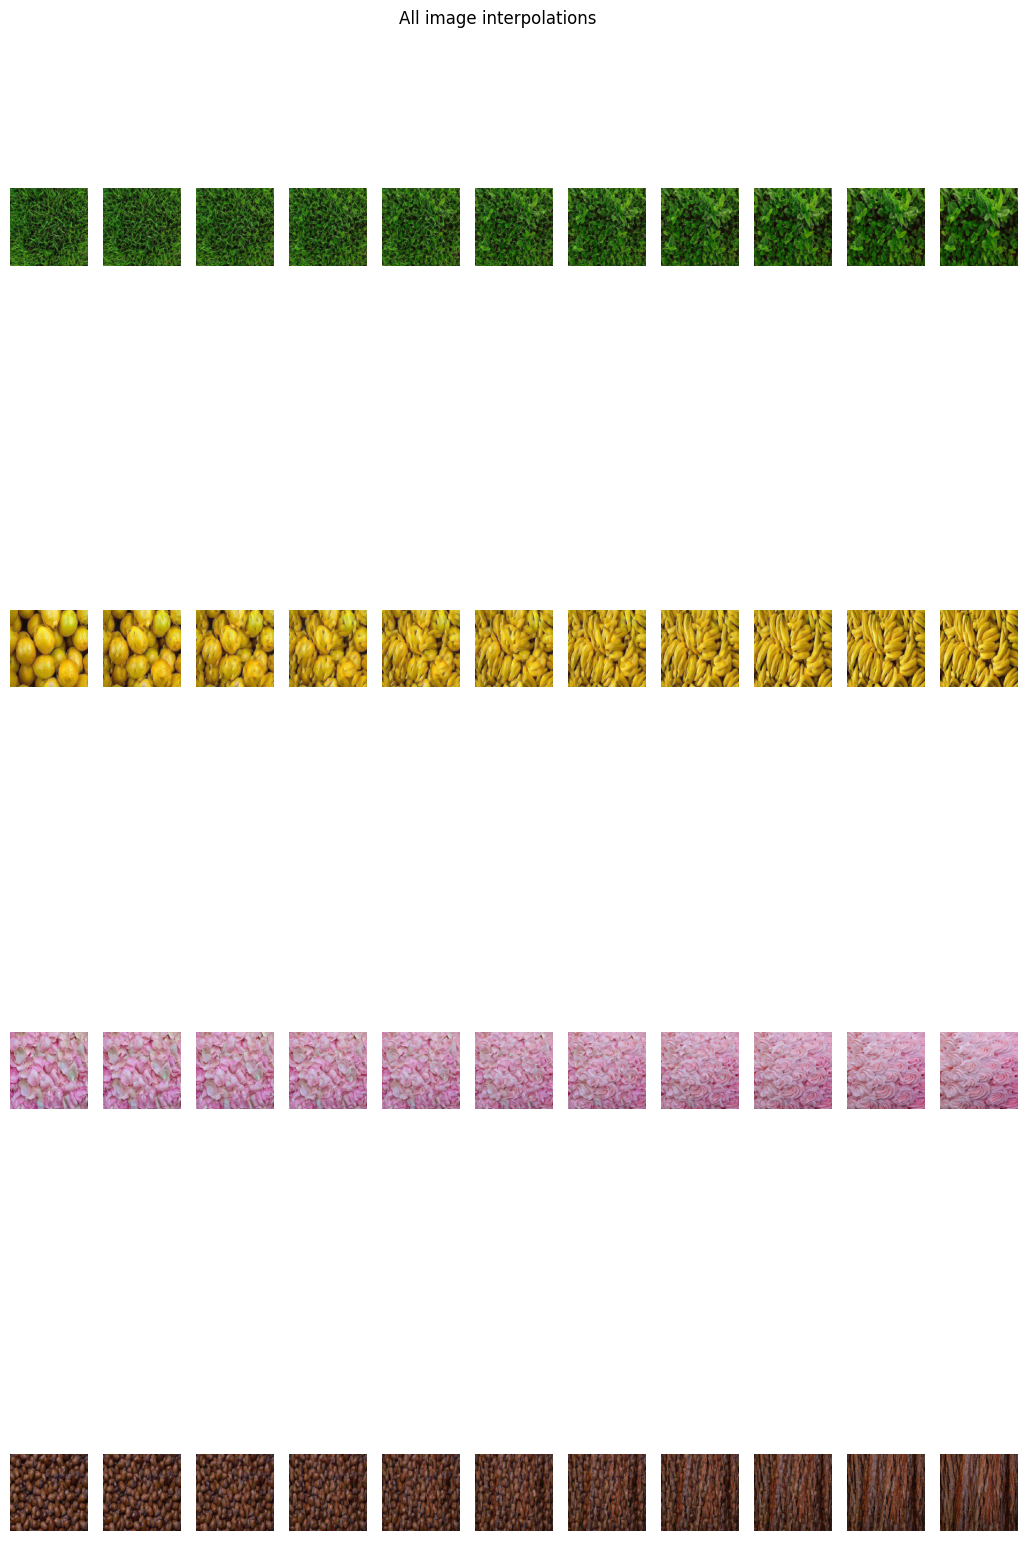

In [2]:
## Pick your model - change model_name to switch ##
model_name = 'ResNet50'  # Change this to the desired model name

#Build the model
model, preprocess_input, input_size = get_model_and_preprocessing(model_name)
layer_names = [layer.name for layer in model.layers]
#conv1 = 1; pool1 = 3; pool2 = 6; pool3 = 11; pool4 = 16; pool5 = 21;



## Get activations of all images ##
# texture or activation loss?
activationLoss = 0;
constraint = '10x10';

# set names of images
#image1Names = ['acorns', 'b1', 'canopy', 'canopy', 'fern', 'fern', 'lemons', 'moss', \
#               'moss', 'mango', 'obsidian', 'ocean', 'pebbles2', 'pine', 'pine', 'redwood', 'rubies', 'snow', ]
#image2Names = ['redwood', 'b6', 'leaves', 'moss', 'grass', 'leaves', 'bananas', 'grass', \
#               'leaves', 'yellowGems', 'licorice', 'sky', 'granite', 'grass', 'moss', 'rockwall', 'cherries', 'pebbles2', ]

#image1Names = ['acorns', 'b1', 'canopy', 'fern', 'petals', 'blueberries', 'fern', 'grass', 'lemons', 'moss2', \
#         'moss3', 'mango', 'obsidian', 'ocean', 'pebbles', 'pine', 'pine2', 'redwood', 'rubies']

#image2Names = ['redwood', 'b6', 'moss', 'grass', 'buttercream', 'beads', 'leaves', 'leaves', 'bananas', 'grass', \
#         'leaves', 'yellowGems', 'licorice', 'sky', 'granite', 'grass', 'moss', 'rockwall', 'cherries']

image1Names = ['grass', 'lemons', 'petals', 'acorns']
image2Names = ['leaves', 'bananas', 'buttercream', 'redwood']

#image1Names = ['grass', 'lemons', ]
#image2Names = ['leaves', 'bananas', ]

# get interp parameters
interpNames = [f"{string1}_{string2}" for string1, string2 in zip(image1Names, image2Names)]
print(interpNames)
interpValues = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, ]

# initialize holds
allActivations = {}; allImages = {}; imageNames = []; imageIndex = 0;

# loop through each interp and get activations
fig, axes = plt.subplots(ncols=len(interpValues), nrows=len(interpNames), figsize=(13, 21)); sub = 0;
for interpName in interpNames:
    for interpValue in interpValues:
        # Load and preprocess your image
        img_path = 'out/' + interpName + '/' + constraint + '/' + \
        image1Names[imageIndex] + '_' + str(interpValue) + '_' + image2Names[imageIndex] + '_' + constraint + '_pool4_smp1.png';
        imageName = interpName + str(interpValue);
        # Different name if doing activation loss images
        if activationLoss == 1:
            img_path = 'fades/' + image1Names[imageIndex] + '_' + str(interpValue) + '_' + image2Names[imageIndex] + '_pool4_smp1.png'
        print(img_path)
        img = image.load_img(img_path, target_size=input_size[:2]);
        x = image.img_to_array(img);
        x = np.expand_dims(x, axis=0);
        x = preprocess_input(x);
    
        # Get the activations at each layer for your image
        layer_outputs = model.predict(x, verbose=0);
    
        # save outputs
        allActivations[imageName] = layer_outputs;
        allImages[imageName] = img;

        # save name of image
        imageNames.append(imageName);

        # plot the image
        im = axes.flatten()[sub].imshow(img)
        axes.flatten()[sub].axis('off')
        sub+=1
    
    #iterate through names
    imageIndex+=1

plt.suptitle('All image interpolations', y=.9);

In [3]:
#allActivations[imageNames[0]][176].shape
#for i, layer in enumerate(model.layers):
#    print(f"Layer {i}: {layer.name} - {layer.output_shape}")

### Calculate distances between images in a specified layer

Next, we'll plot the dissimilarities between the interpolations for every image pair. Dissimilarity is just the L1 distance between the activations of all the features in a specified layer. The hope is that the corners (non-interpolated synthesized images) will be the furthest apart from eachother, and the intermediates will be... well, intermediate. Maybe even somewhat linear would be great.

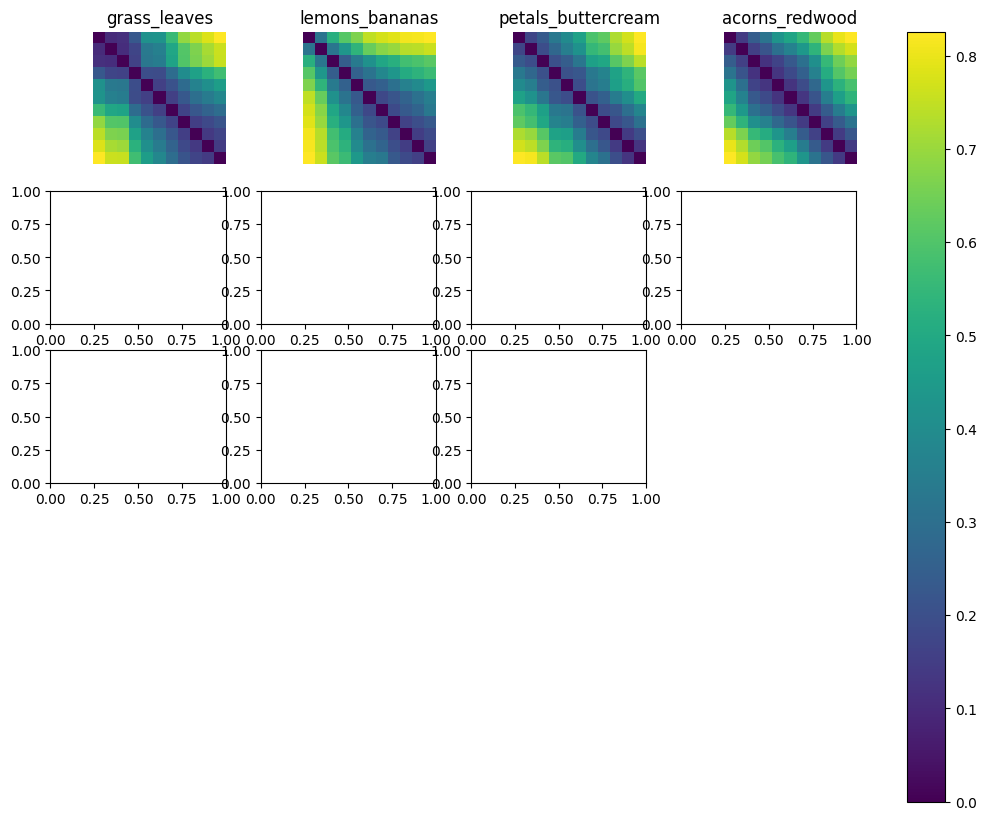

In [4]:
# set your layer - numbers defined earlier
layer = pool5

# get L1 distance between all images
distances = np.zeros((len(imageNames),len(imageNames)))
for im1 in range(len(imageNames)):
    for im2 in range(len(imageNames)):
        #distances[im1,im2] = np.sum(np.abs(allActivations[imageNames[im1]][layer] - allActivations[imageNames[im2]][layer]))
        distances[im1,im2] = scipy.spatial.distance.cosine(allActivations[imageNames[im1]][layer].flatten(), allActivations[imageNames[im2]][layer].flatten())

# pull out the individual interpolations
singleInterpDistanceMatrices = {}; nameIndex = 0;
for interpImage in range(0, distances.shape[0], len(interpValues)):
    singleInterpDistanceMatrices[interpNames[nameIndex]] = \
    distances[interpImage:interpImage+len(interpValues), interpImage:interpImage+len(interpValues)];
    
    nameIndex+=1

# plot individual matrices
avgDistance = np.zeros((len(interpValues), len(interpValues)))
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(13, 10))
for sub in range(len(interpNames)):
    im = axes.flatten()[sub].imshow(singleInterpDistanceMatrices[interpNames[sub]])
    axes.flatten()[sub].set_title(interpNames[sub])
    axes.flatten()[sub].axis('off')
    avgDistance += singleInterpDistanceMatrices[interpNames[sub]]

# hide extra subplots
for ax in axes.flatten()[len(interpValues):]:
    ax.axis('off')
    
fig.colorbar(im, ax=axes);

Ok - they look alright. Some of them look pretty good (lemons_bananas looks decent for example, or fern_leaves) but others look kind of noisy. Is that noisyness actual noise? When we synthesized the images, we only ran for 2,000 training iterations - so it's possible that the noisyness (e.g. why is .9 in snow/pebbles more distance from 0 than 1?) is because of the optimization for the original images running long enough. 

One way we can test this is by looking at the average distance matrix:

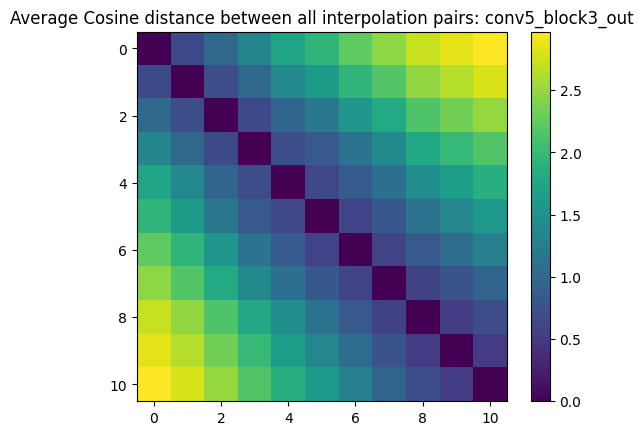

In [5]:
# Plot the averaged dissimilarity matrix
plt.imshow(avgDistance);
plt.title('Average Cosine distance between all interpolation pairs: ' + layer_names[layer]);
plt.colorbar();

This looks pretty good. I'm willing to believe that the noise is from the optimization. I'm also willing to believe that some pairs of images will always be more noisy, probably as a function of low level featural dissimilarity (e.g. in snow_pebbles, the pebbles have a lot more defined edges - so maybe the in-between is kind of weird. Maybe the jump from no edges to few edges is much bigger than few edges to moderate amount of edges [where "edges" is actually some arbitrary feature]). Worth thinking about when picking images for behavior.

### Try and do some MDS on the distances

Back to this linearity thing - it would be nice if there was a linear distance relationship along the interoplation. E.g. grass is 100 away from pebbles, grass_pebbles_0.5 is 50 away from both of them, grass_pebbles_0.3 is 30 from grass, 70 from pebbles, etc. 

One way to test this is by projecting the distance matrix downwards and visualizing it. We'll do so here with multidimensional scaling. Here, I'm projecting down into 2 arbitrary dimensions and plotting all of the interps.

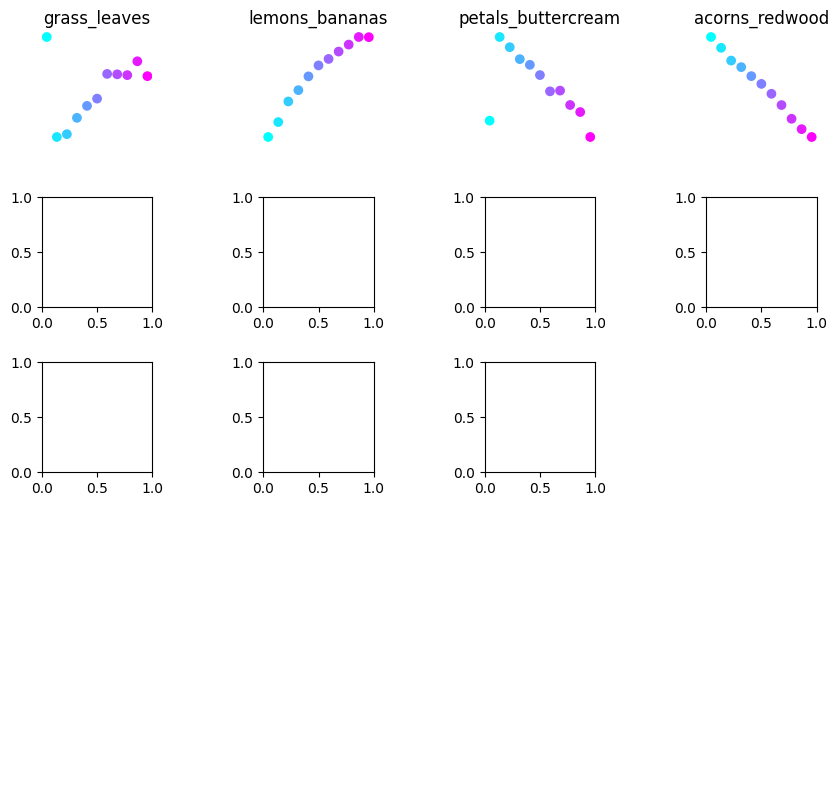

In [6]:
# initialize mds, figure, and scatterplot colors
mds = MDS(n_components=1, dissimilarity='precomputed')
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 10), gridspec_kw={'hspace': .5, 'wspace': 1})
colors = [i for i in range(0, 11)]

# plot every mds projection from the distance matrices
for sub in range(len(interpNames)):
    embedded_distances = mds.fit_transform(singleInterpDistanceMatrices[interpNames[sub]])

    ax = axes.flatten()[sub]
    ax.scatter(range(11),embedded_distances[:, 0], c=colors, cmap = 'cool')
    ax.set_title(interpNames[sub])
    axes.flatten()[sub].axis('off')
    #for i, (x, y) in enumerate(zip(embedded_distances[:, 0], embedded_distances[:, 1])):
    #    ax.text(x, y, imageNames[i][-3:], fontsize=8, ha='right')

# hide extra subplots
for ax in axes.flatten()[len(interpValues):]:
    ax.axis('off')

Let's do the same thing for the average distance matrix:

Text(0.5, 1.0, 'Average mds projection: conv5_block3_out')

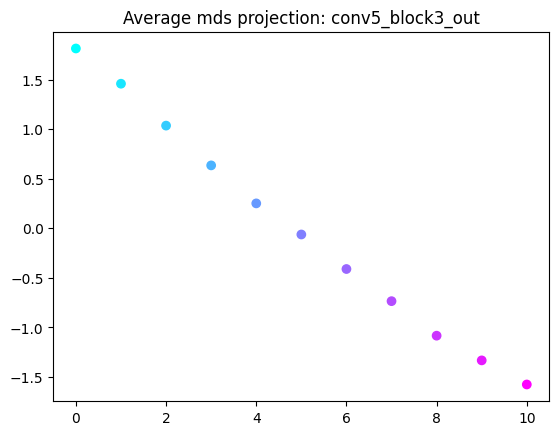

In [7]:
# plot the mds projection of the average distance matrix
avg_embedded_distances = mds.fit_transform(avgDistance)

plt.scatter(range(11), avg_embedded_distances[:, 0], c=colors, cmap='cool')
plt.title('Average mds projection: ' + layer_names[layer])
#for i, (x, y) in enumerate(zip(avg_embedded_distances[:, 0], avg_embedded_distances[:, 1])):
#    plt.text(x, y, imageNames[i][-3:], fontsize=8, ha='right')

It looks... OK. Clearly these aren't totally linear in high-dimensional space, which is ok. It seems like it's always the case that the jump from 0 to .1 is more than 10x the jump from 0 to 1. Maybe a noise thing. It might also be the case that there is just a non-linear jump when you are introducing new features. Promisingly, some of these projections to seem to follow a curve, even if it isn't straight (ocean_sky is usually a good example. The average is as well). 

### Let's try the same thing on the average with tsne at different levels of perplexity

t-sne is an alternative to mds. It is still a downward projection, but whereas mds is specifically an algorithm to capture global relationships, with t-sne you can parameterize the number of neighbors you'd like to consider in the projection (measure of perplexity).

python(11501) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


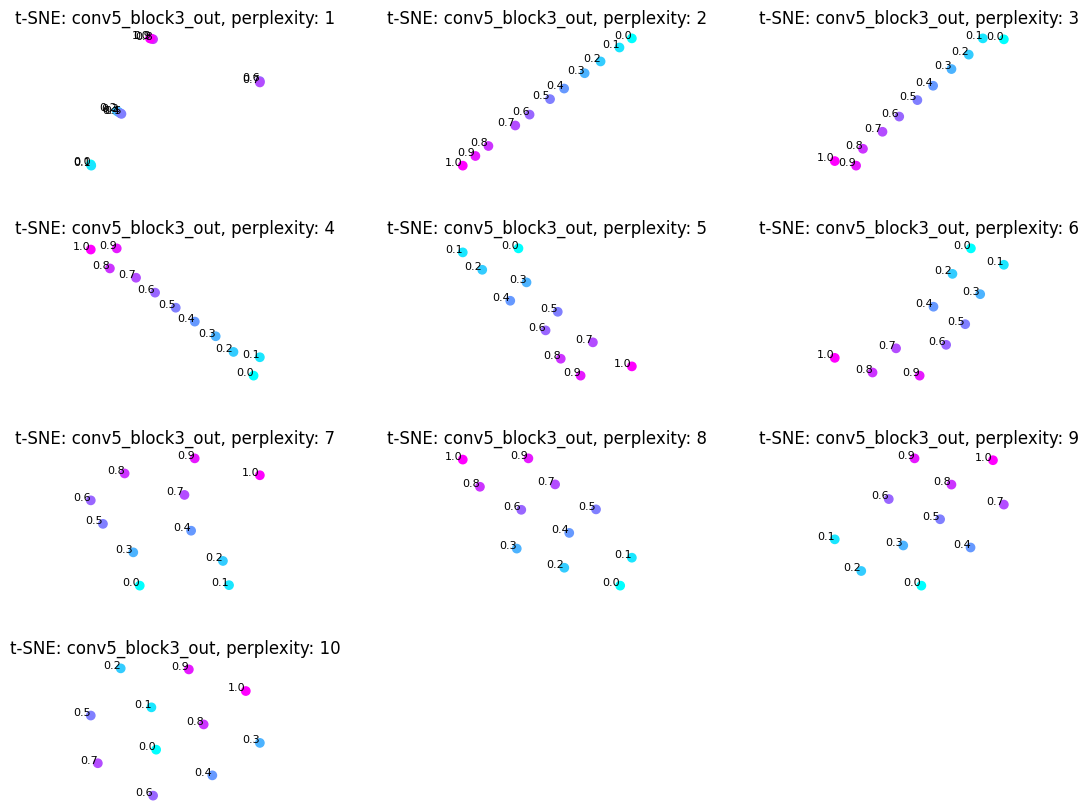

In [8]:
# let's try tsne...
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 10), gridspec_kw={'hspace': .5, 'wspace': 1})

sub = 0
for perp in range(1,11):
    tsne = TSNE(n_components=2, perplexity = perp) 
    avg_embedded_tsne = tsne.fit_transform(avgDistance)
    
    # plot it
    ax = axes.flatten()[sub]
    ax.scatter(avg_embedded_tsne[:, 0], avg_embedded_tsne[:, 1], c=colors, cmap='cool')
    ax.set_title('t-SNE: ' + layer_names[layer] + ', perplexity: ' + str(perp))
    axes.flatten()[sub].axis('off')
    
    # label interps
    for i, (x, y) in enumerate(zip(avg_embedded_tsne[:, 0], avg_embedded_tsne[:, 1])):
        ax.text(x, y, imageNames[i][-3:], fontsize=8, ha='right')

    sub+=1

# hide extra subplots
for ax in axes.flatten()[10:]:
    ax.axis('off')

It looks pretty good at low perplexity (2-6, as it should). Like mds, it doesn't do great with global structure. It does OK - thank god - but it's pretty far from our desired linearity.

## Maximum likelihood distance scaling on NN activations
Next, we'll take a different measure of how far apart the activations are from eachother. This is the "Maximum likelihood distance scaling" approach from Maloney and Yang. You take 2 pairs of images and ask the network which is more dissimilar (greater L1 distance between the pairs). You can fit scalar values to each of the images such that they are all given values from 0 to 1.

In [9]:
# define loss function to compute scaling values
def compute_loss(params, all_combinations, biggerDiff):
    psi = params[:11]
    sigma = params[11]
    
    # make a copy here of all the combinations
    all_combinations_copy = np.copy(all_combinations)
    all_combinations_copy = all_combinations_copy/10
    
    # replace with the psi values
    for interp_val in range(11):
        all_combinations_copy[all_combinations == interp_val] = psi[interp_val]

    # calculate the differences and probabilitys
    diffs = np.abs(all_combinations_copy[:, 0] - all_combinations_copy[:, 1]) - np.abs(all_combinations_copy[:, 2] - all_combinations_copy[:, 3])
    total_prob = 0
    for response_num in range(len(diffs)):
        if biggerDiff[response_num] == 1:
            prob_response = -np.log(norm.cdf(diffs[response_num], 0, sigma))
            total_prob += prob_response
        elif biggerDiff[response_num] == 2:
            prob_response = -np.log(1-norm.cdf(diffs[response_num], 0, sigma))
            total_prob += prob_response
    return total_prob

In [10]:
# make combinations
#all_combinations = np.zeros((330,4))  # Initialize array to hold combinations
#col = 0

#for i in range(0, len(interpValues)):
#    for j in range(i + 1, len(interpValues)):
#        for k in range(j + 1, len(interpValues)):
#            for l in range(k + 1, len(interpValues)):
#                all_combinations[col,:] = np.array([round(i), round(j), round(k), round(l)])
#                col += 1

#all_combinations = np.array(all_combinations)

# make all of the different permutations. this is way, way too long - will fix later.
#all_combinations = np.array(list(itertools.product(range(0,len(interpValues)), repeat=4)))

# do it like in the human experiment - random numbers
all_combinations = np.random.randint(0, 11, size=(2000, 4))

Optimization terminated successfully.
         Current function value: 392.305990
         Iterations: 987
         Function evaluations: 1362
Optimization terminated successfully.
         Current function value: 376.320551
         Iterations: 726
         Function evaluations: 1024
Optimization terminated successfully.
         Current function value: 214.891014
         Iterations: 878
         Function evaluations: 1235
Optimization terminated successfully.
         Current function value: 305.178017
         Iterations: 727
         Function evaluations: 1014
Optimization terminated successfully.
         Current function value: 217.271810
         Iterations: 787
         Function evaluations: 1097
Optimization terminated successfully.
         Current function value: 232.638631
         Iterations: 636
         Function evaluations: 909
Optimization terminated successfully.
         Current function value: 144.599961
         Iterations: 681
         Function evaluations: 948
O

/var/folders/ft/tx41jkc54x7213gqj_0sl43w0000gn/T/ipykernel_11493/1079905861.py:22: RuntimeWarning: divide by zero encountered in log
  prob_response = -np.log(1-norm.cdf(diffs[response_num], 0, sigma))


Optimization terminated successfully.
         Current function value: 91.756821
         Iterations: 683
         Function evaluations: 970
Optimization terminated successfully.
         Current function value: 76.746049
         Iterations: 588
         Function evaluations: 845
Optimization terminated successfully.
         Current function value: 113.197418
         Iterations: 720
         Function evaluations: 1023
Optimization terminated successfully.
         Current function value: 105.248894
         Iterations: 565
         Function evaluations: 818
Optimization terminated successfully.
         Current function value: 101.658292
         Iterations: 654
         Function evaluations: 922
Optimization terminated successfully.
         Current function value: 69.036050
         Iterations: 884
         Function evaluations: 1246
Optimization terminated successfully.
         Current function value: 82.515978
         Iterations: 593
         Function evaluations: 852
Optimiza

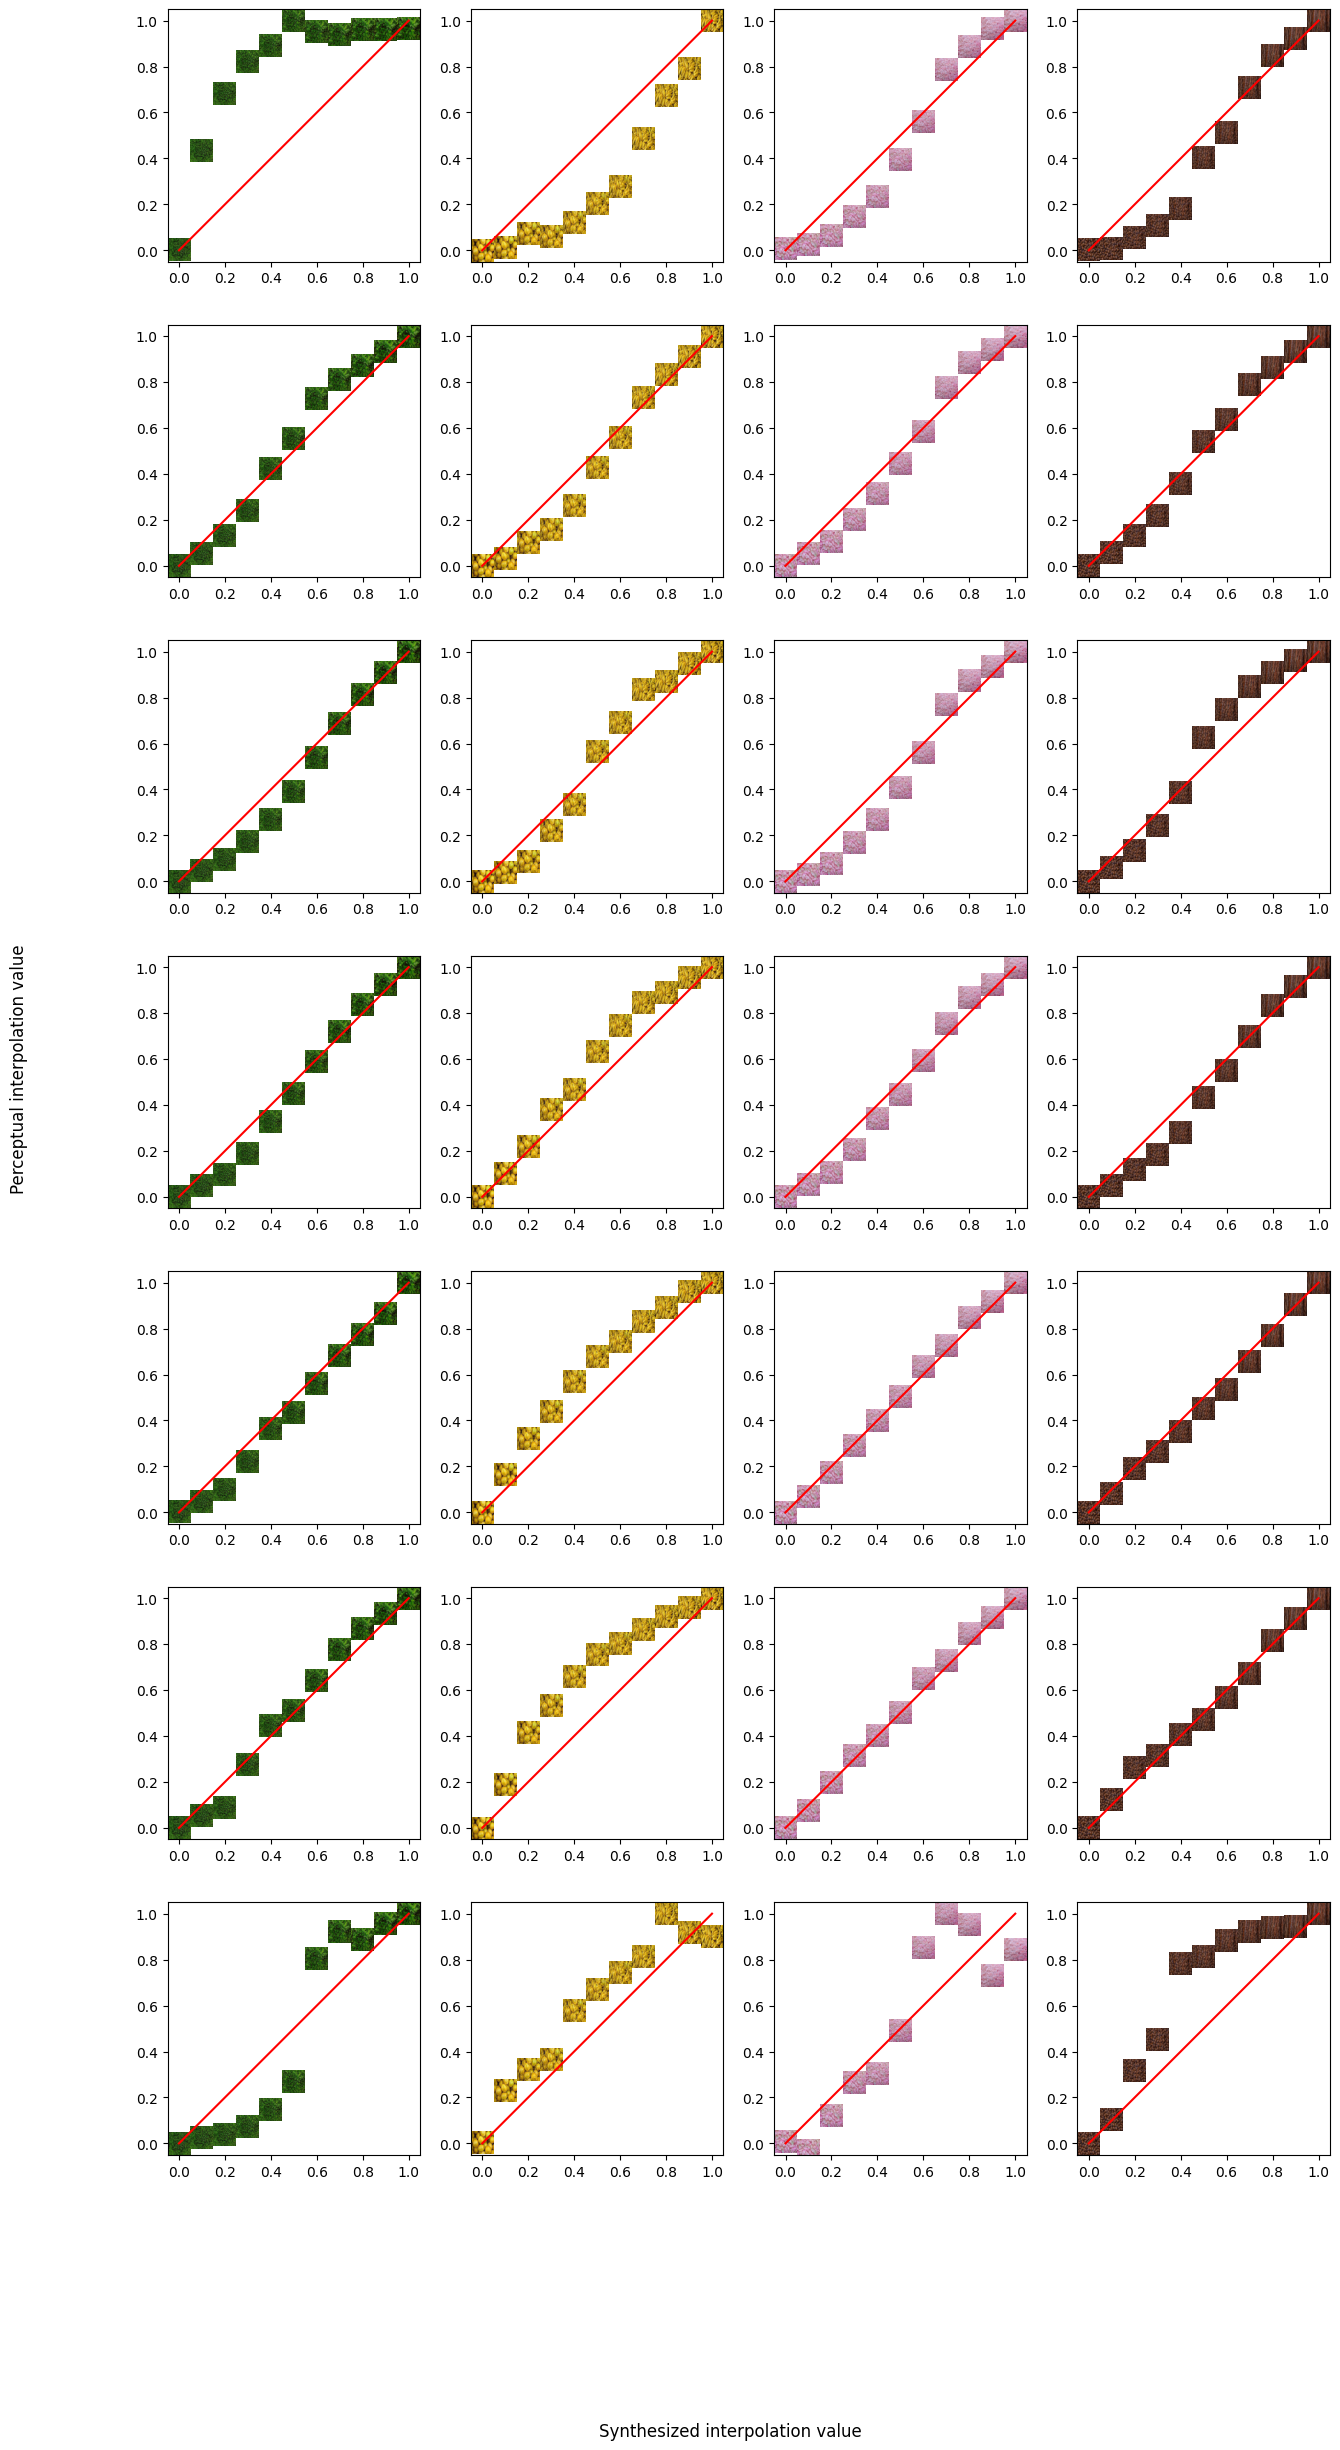

In [11]:
# pick which layers you want to look at
layers = [conv1, pool1, pool2, pool3, pool4, pool5, end]
#layers = [pool5]

# init a figure
fig = plt.figure(figsize=(15, 4*len(layers)))
sub = 0;

for layer in layers:

    # iterate through interpolations
    for interpPair in range(len(interpNames)):
        
        # make some empty lists to keep track
        biggerDiff = [];
        
        for pairings in all_combinations.astype(int):
            # add which interp number this is by adding amount of pairs you've iterated * num interp values
            pairings = tuple(x + interpPair*len(interpValues) for x in pairings)
            # get the index from all activations to the pairs
            im1 = pairings[0]; im2 = pairings[1]; im3 = pairings[2]; im4 = pairings[3];
            # calcuate the distances
            dist12 = scipy.spatial.distance.cosine(allActivations[imageNames[im1]][layer].flatten(), allActivations[imageNames[im2]][layer].flatten())
            dist34 = scipy.spatial.distance.cosine(allActivations[imageNames[im3]][layer].flatten(), allActivations[imageNames[im4]][layer].flatten())
            if dist12 > dist34:
                biggerDiff.append(1)
            elif dist34 > dist12:
                biggerDiff.append(2)
            else:
                biggerDiff.append(0)
        
        
        # set up initial params
        psi = np.arange(0, 11)/10 #np.random.rand(11)#
        sigma = 0.2
        initial_params = np.concatenate((psi, [sigma]))
        
        # search for params
        optimal_params = fmin(compute_loss, initial_params, args=(all_combinations, biggerDiff));
        psi = optimal_params[:11]
        psi = psi / np.max(psi)
        
        # plot it
        plt.subplot(len(layers),len(image1Names),interpPair+1+sub*len(image1Names))
        
        # iterate over interp_values
        for interp_value in range(11):
            im = interpPair * len(interpValues) + interp_value
            plt.imshow(allImages[imageNames[im]], extent=[(interp_value ) / 10 - 0.05, (interp_value) / 10 + 0.05, psi[interp_value] - 0.05, psi[interp_value] + 0.05])
       
        # set axis limits
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.plot([0, 1], [0, 1], 'r')

    sub += 1        
# show the plot
fig.supylabel('Perceptual interpolation value')
fig.supxlabel('Synthesized interpolation value')
plt.show()

In [12]:
indices = [pool1, pool2, pool3, pool4, pool5]
result = [allActivations[imageNames[21]][index].flatten() for index in indices]
final = np.concatenate(result)
final.shape

(1705984,)

In [13]:
layers

[2, 6, 38, 80, 142, 174, 176]

### Interim Conclusion - neural network dissimilarity

Generally, the dissimilarity matrices look pretty good - they seem relatively smooth as you interpolate between images. The projections of that dissimilarity into 2d space is ok - it clearly is not linear. Some more so than others.
 
So the next questions are:
 
1. Why isn't the 2-d projection linear? Is this because we are optimizing the gramian and then comparing activations? Would the gramian interpolation look linear? Is it because we are not running enough optimization steps?

2. Would a neural interpolation look more/less linear? It might improve because we might end up discarding the vgg19 features that are causing the activations to differ from a linear interpolation. Maybe it would be worse, or the same, for the same reason.

## az

## Transformation into predicted voxel space
Next, we'll do the same sort of analyses but transforming everything into voxel space. To do so, we'll find a dimensionality reduction (PCA) of some layer of vgg19 for all of the NSD images, then linear transformation of the reduction to the NSD measured voxel activity. We'll take those transforms and apply them to our images to get predicted voxel responses to our interpolated images. Then we'll do a similar analysis.